# Intro

In [1]:
import numpy as np
import xarray as xr
import geopandas as gpd
import pyproj as prj
import shapely
import matplotlib.pyplot as plt

In [2]:
import preseis.source_location as sl
import preseis.dgm_velmod_sampler as dvs

In [3]:
velmodfile = "/mnt/d/Cache/VELMOD31_UTM31.h5"
velmod_UTM = xr.load_dataset(velmodfile, decode_coords="all")
dgmfile = "/mnt/d/Cache/DGM5_UTM31.h5"
dgm_UTM = xr.load_dataset(dgmfile, decode_coords="all")

In [4]:
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

In [5]:
crs_UTM, crs_RD = prj.CRS("EPSG:23031"), prj.CRS("EPSG:28992")
RD_to_UTM = prj.Transformer.from_crs(crs_RD, crs_UTM)
UTM_to_RD = prj.Transformer.from_crs(crs_UTM, crs_RD)

# Define region

Just as an example, choose the location of the Onze Lieve Vrouwetoren in Amersfoort, the center of the national RD grid, as the reference point of the region of interest.

In [6]:
x_RD = 155_000
y_RD = 463_000

Randomly place a number of stations within a radius around the reference point.

In [7]:
n_station = 6
radius = 5_000
x = x_RD + radius * (-0.5 + rng.random(n_station))
y = y_RD + radius * (-0.5 + rng.random(n_station))
stat_locs = gpd.points_from_xy(x, y, crs=28992)
stations_gpd = gpd.GeoDataFrame(geometry=stat_locs)

Construct a bounding box with a buffer around the stations.

In [8]:
bx = shapely.box(*stations_gpd.total_bounds)
bounding_box = shapely.box(
    *shapely.total_bounds(bx.buffer(1000, join_style=2)).round(-2)
)
minx, miny, maxx, maxy = shapely.total_bounds(bounding_box)

In [9]:
st_minx, st_miny, st_maxx, st_maxy = shapely.total_bounds(bx)

Display georeferenced map of the region of interest.

In [10]:
pl = gpd.GeoDataFrame(geometry=[bounding_box], crs=28992)
m = pl.explore()
stations_gpd.explore(m=m, color="red")

In [11]:
stations_gpd["x"] = stations_gpd.centroid.map(lambda p: p.x)
stations_gpd["y"] = stations_gpd.centroid.map(lambda p: p.y)
stations = xr.Dataset.from_dataframe(stations_gpd.drop(columns=["geometry"])).rename(
    {"index": "station"}
)
stations["station"] = stations["station"].astype(str)
stations["z"] = xr.full_like(stations["x"], 0.0)
stationlist = stations[["x", "y", "z"]].to_array("location")

# Create DGM/VELMOD velocitygrid

Determine RD grid for velocity and traveltime modelling

In [12]:
spacing = 50.0
xmin, ymin, zmin = minx, miny, -3000.0
xmax, ymax, zmax = maxx, maxy, 0.0
xsmp = np.arange(xmin, xmax + spacing, spacing)
ysmp = np.arange(ymin, ymax + spacing, spacing)
zsmp = np.arange(zmin, zmax + spacing, spacing)

grid = (
    xr.Dataset(
        coords={
            "x": xsmp,
            "y": ysmp,
            "z": zsmp,
        }
    )
    .rio.write_crs("EPSG:28992")
    .rio.write_coordinate_system()
)

Transform to UTM, then sample DGM/VELMOD

In [13]:
x_UTM, y_UTM = xr.apply_ufunc(
    RD_to_UTM.transform,
    grid["x"],
    grid["y"],
    output_core_dims=[[], []],
    vectorize=True,  # prj Transformers do not broadcast to dim>1
    keep_attrs=True,
)

In [14]:
RD_grid = dvs.sample_dgm_velmod(x_UTM, y_UTM, grid["z"], dgm=dgm_UTM, velmod=velmod_UTM)

# Add S-velocity model

In [15]:
# simply start with Castagna: Vp = 1.16*Vs + 1360.
a_castagna = xr.DataArray([1.0, 1.16], dims="mode", coords={"mode": ["P", "S"]})
b_castagna = xr.DataArray([0.0, 1360.0], dims="mode", coords={"mode": ["P", "S"]})
RD_grid["V0_PS"] = (RD_grid["V0"] - b_castagna) / a_castagna
RD_grid["Vinst_PS"] = (RD_grid["Vinst"] - b_castagna) / a_castagna

Plot cross sections

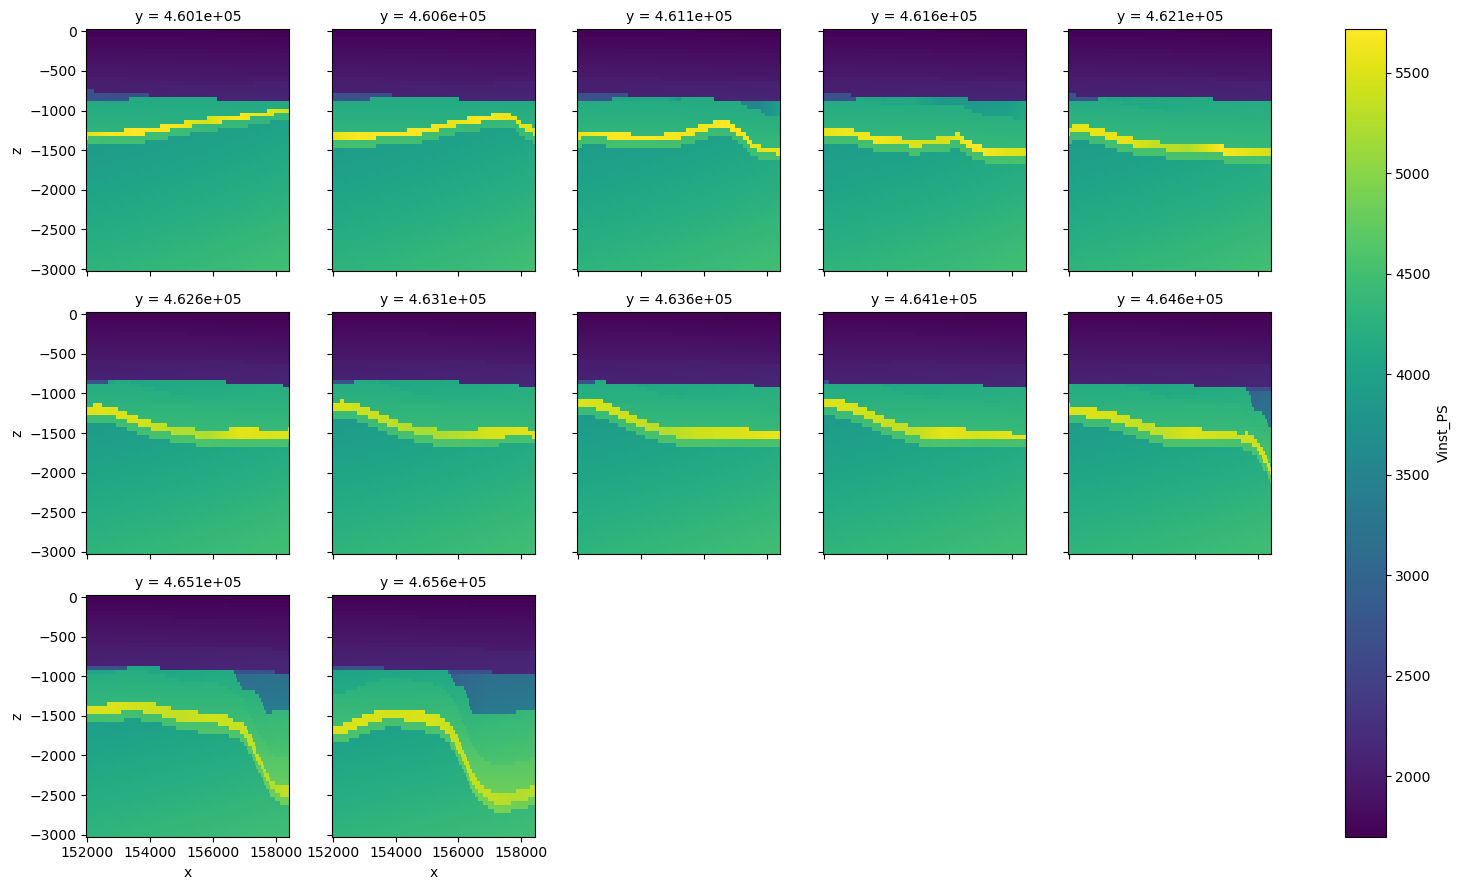

In [16]:
_ = (
    RD_grid["Vinst_PS"]
    .sel(mode="P")
    .isel({"y": slice(0, -1, 10)})
    .plot(x="x", y="z", col="y", col_wrap=5)
)

# Generate travel times using pykonal

Extract origin and spacing

In [17]:
origin = [x[0] for x in RD_grid[["x", "y", "z"]].indexes.values()]
spacing = [x[1] - x[0] for x in RD_grid[["x", "y", "z"]].indexes.values()]

Calculate synthetic travel times from all stations to all subsurface points

In [18]:
synth_tt = xr.apply_ufunc(
    sl.eikonal_solve,
    stationlist,
    RD_grid["Vinst_PS"],
    input_core_dims=[["location"], ["x", "y", "z"]],
    output_core_dims=[["x", "y", "z"]],
    exclude_dims={"location", "x", "y", "z"},
    kwargs={"origin": origin, "delta": spacing},
    output_dtypes=[float],
    vectorize=True,
).assign_coords(RD_grid["Vinst_PS"].coords)

Display stations and travel times at some depth

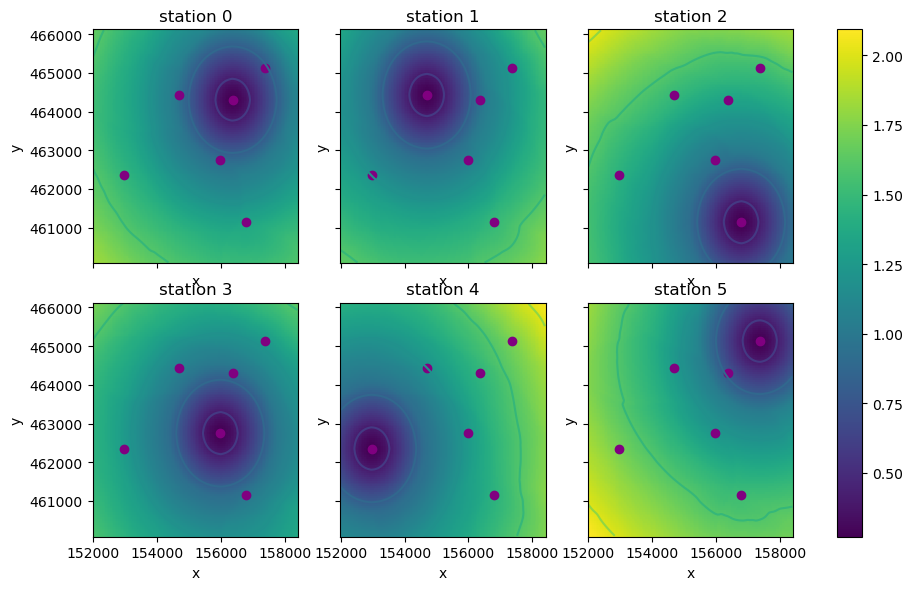

In [19]:
g = (
    synth_tt.interp({"z": -500.0})
    .sel({"mode": "P"})
    .plot(x="x", y="y", col="station", col_wrap=3)
)
g.map_dataarray(xr.plot.contour, x="x", y="y", add_colorbar=False)
g.map(lambda: xr.plot.scatter(ds=stations, x="x", y="y", color="purple"))
for ax, name in zip(g.axs.flat, synth_tt["station"].values):
    ax.set_title(f"station {name}")

# Define covariance structure

Define some covariance structure, using marginal standard deviations for the modes, and correlation coefficients between te modes.

In [20]:
sigma_P, sigma_S = 0.04, 0.1
sigma = xr.DataArray([sigma_P, sigma_S], coords={"mode": ["P", "S"]})

In [21]:
mode_correlation_coefficient = 0.5
mode_correlation_matrix = xr.DataArray(
    data=[
        [1.0, mode_correlation_coefficient],
        [mode_correlation_coefficient, 1.0],
    ],
    coords={
        "mode": ["P", "S"],
        "mode_T": ["P", "S"],
    },
)

Define spatial correlation model

In [22]:
def spatial_correlation_coefficient(loc0, loc1, corr_len):
    # determine distance
    reldist2 = np.sum(((loc1 - loc0) / corr_len) ** 2)
    # determine spatial correlation coefficient
    return np.exp(-0.5 * reldist2)

In [23]:
spatial_correlation_length = 2000.0

# create correlation matrix
# use different name for second station dimension to broadcast
spatial_correlation_matrix = xr.apply_ufunc(
    spatial_correlation_coefficient,
    stationlist,
    stationlist.rename({"station": "station_T"}),
    spatial_correlation_length,
    input_core_dims=[["location"], ["location"], []],
    output_core_dims=[[]],
    exclude_dims={"location"},
    vectorize=True,
)

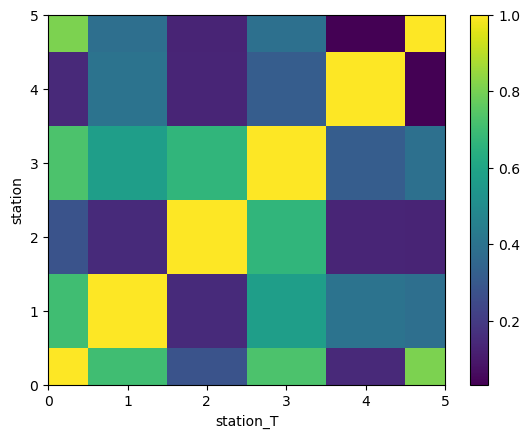

In [24]:
_ = spatial_correlation_matrix.plot()

Complete covariance structure

In [25]:
covariance_structure = (
    sigma
    * sigma.rename({"mode": "mode_T"})
    * spatial_correlation_matrix
    * mode_correlation_matrix
)

# Plot function

In [26]:
def source_plot_with_ellipses(spatdist, md, row, frac):
    sd = ["x", "y", "z"]
    sd.remove(md)
    coor_sel = {"space": sd, "space_T": sd}

    sp = spatdist.sel(coor_sel).transpose("source", row, ...)

    posterior = np.exp(sp["logposterior"])
    g = (posterior.sum([md]) / posterior.sum([md]).max(sd)).plot(
        x=sd[0], y=sd[1], col="source", row=row, cmap="BuGn", add_colorbar=False
    )

    spstack = sp.stack({"flat": [row, "source"]})

    for i, ax in enumerate(g.axs.flat):
        sploc = spstack.isel({"flat": i})

        mn = sploc["location_mean"]
        cov = sploc["covariance_integral"]

        el = sl.covariance_ellipse(mn, cov, frac, edgecolor="b")
        ax.add_artist(el)

        astats = sploc["station"].where(sploc["active_stations"], drop=True)
        st = stations.sel({"station": astats})
        ax.scatter(
            st[sd[0]],
            st[sd[1]],
            color="red",
            marker="v",
            label="station",
        )

        source_loc = {
            "x": sploc["source_X"],
            "y": sploc["source_Y"],
            "z": sploc["source_Z"],
        }
        ax.scatter(
            source_loc[sd[0]],
            source_loc[sd[1]],
            marker="+",
            s=50,
            color="black",
            label="source",
        )
    plt.legend(loc="lower left", fancybox=True, fontsize=8)

# Resolution analysis for discrete sources

Simulate sources by interpolating the travel time fields at a collection of source points.

In [27]:
obs_sources_z = xr.DataArray([-1000.0, -2500.0], dims="source_z")
obs_sources_x = xr.DataArray(
    [st_minx, 0.5 * (st_minx + st_maxx), st_maxx], dims="source"
)
obs_sources_y = xr.full_like(obs_sources_x, y_RD)

# interpolate travel time field for these specific sources
obs_tt = (
    synth_tt.interp(
        {
            "x": obs_sources_x,
            "y": obs_sources_y,
            "z": obs_sources_z,
        },
    )
    .stack({"data": ["station", "mode"]})
    .reset_index("data")
)

Determine residuals

In [28]:
residuals_tt = obs_tt - synth_tt.sel(
    {"station": obs_tt["station"], "mode": obs_tt["mode"]}
)

And corresponding covariance matrix

In [29]:
cov_matrix = covariance_structure.sel(
    {
        "mode": obs_tt["mode"],
        "mode_T": obs_tt["mode"].rename({"data": "data_T"}),
        "station": obs_tt["station"],
        "station_T": obs_tt["station"].rename({"data": "data_T"}),
    }
)

Characterize the spatial probability distribution for all sources

In [30]:
spatdist = sl.characterize_spatial_distribution(
    data=residuals_tt,
    data_covariance=cov_matrix,
    input_dyad=["data", "data_T"],
    verbose=True,
)

STAGE 1: determine posterior distribution
...demean residuals
...determine likelihood and posterior
STAGE 2: characterize posterior distribution
...determine maximum likelihood (ML) location and covariance
...determine maximum a posterior (MAP) location and covariance
...determine posterior moments


In [31]:
spatdist["source_X"] = obs_sources_x
spatdist["source_Y"] = obs_sources_y
spatdist["source_Z"] = obs_sources_z

marginalized over z
marginalized over y
marginalized over x


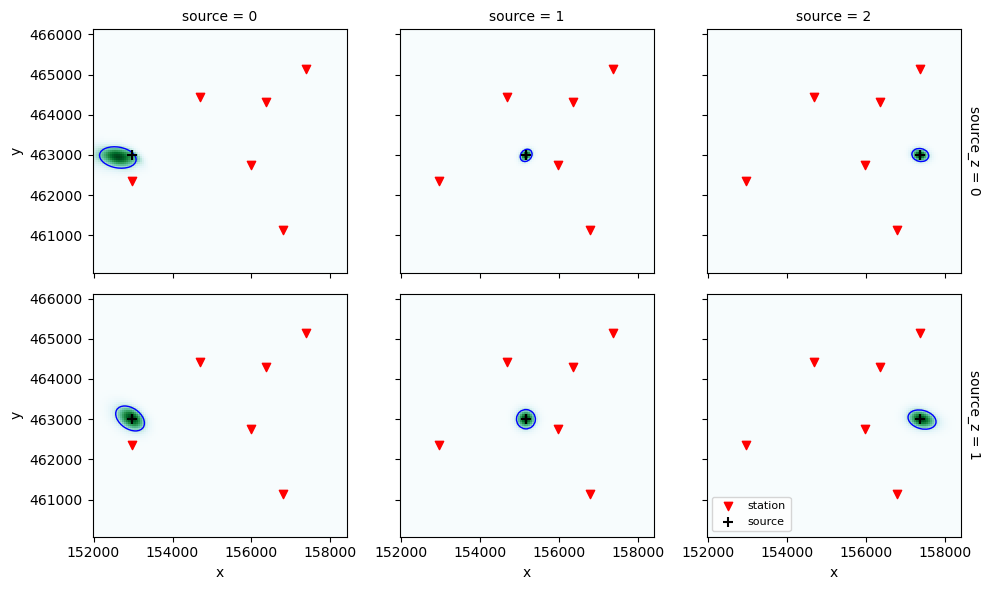

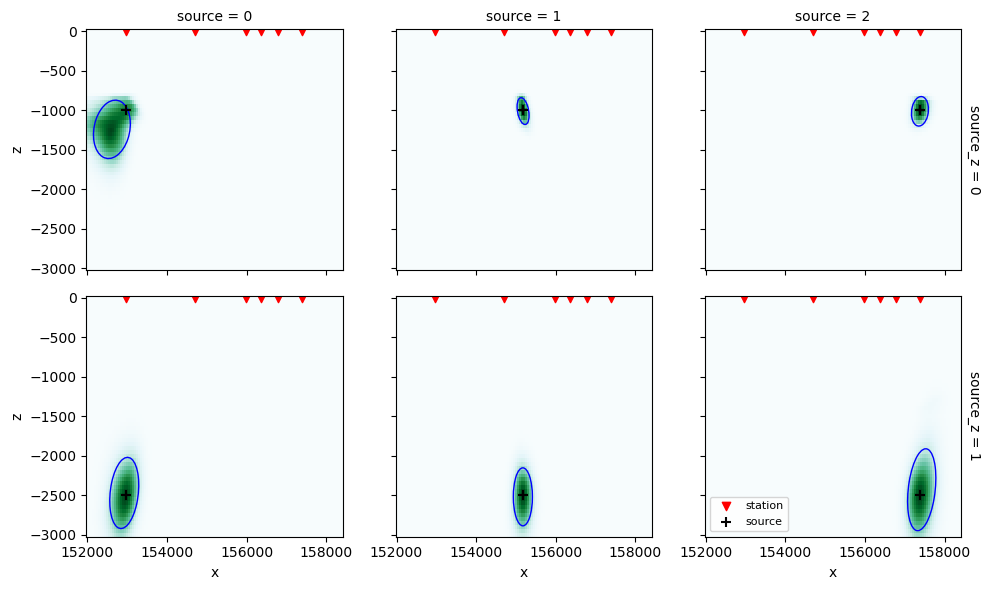

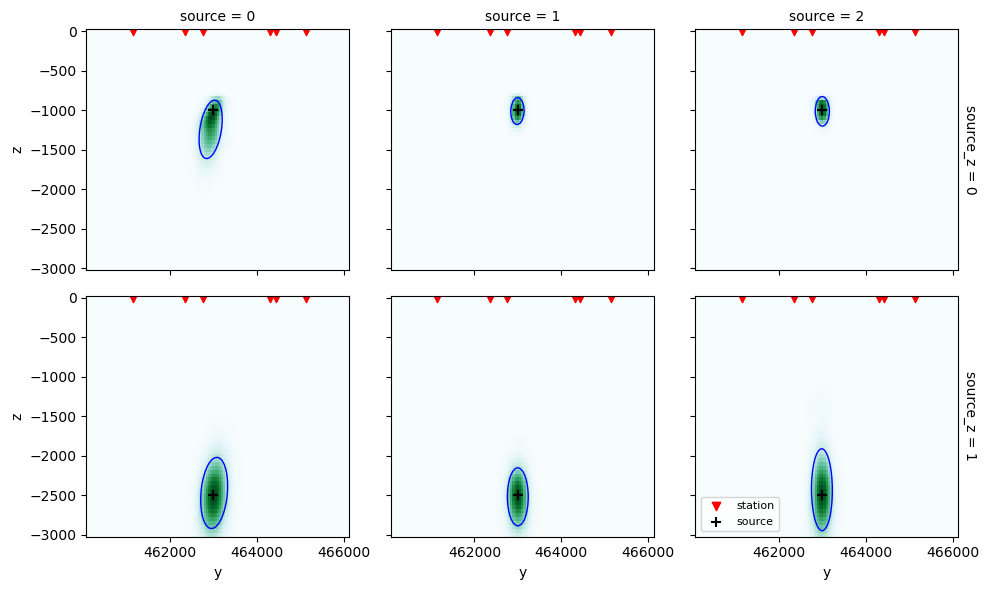

In [32]:
row = "source_z"
frac = 0.68
for md in reversed(["x", "y", "z"]):
    print(f"marginalized over {md}")
    source_plot_with_ellipses(spatdist, md, row, frac)